Narrative:

You are given a data set 'IEA_Electricity.csv' that contains electricity data from many countries affiliated with the International Energy Agency. Locate the Australia electricity ‘Final Consumption (Calculated)’ in the Balance column. This consumption is in terms of number of gigawatts-hour per month from Jan 2010 to Sep 2022.


Requirements:

Perform time series analyses on this Australian consumption pattern. Let this consumption time series be represented by C(t) where t is the monthly time index. (Hint: You can use the following in ipynb to invert the order of the series Cons. Or you can first use Excel to do some data manipulation before calling into Python.)

C=Cons[::-1]

C=C.reset_index(drop=True)

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.linalg import toeplitz
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
# auto_arima function to automatically determine the pdqPDQ from raw prices
import pmdarima as pm

In [32]:
df = pd.read_csv('IEA_Electricity.csv')

In [33]:
df

,Country,Time,Balance,Product,Value,Unit
0,Australia,Sep-22,Net Electricity Production,Electricity,21161.5036,GWh
1,Australia,Sep-22,Net Electricity Production,Total Combustible Fuels,13777.8878,GWh
2,Australia,Sep-22,Net Electricity Production,"Coal, Peat and Manufactured Gases",9631.9664,GWh
3,Australia,Sep-22,Net Electricity Production,Oil and Petroleum Products,333.9555,GWh
4,Australia,Sep-22,Net Electricity Production,Natural Gas,3566.2116,GWh
...,...,...,...,...,...,...
126318,IEA Total,Jan-10,Total Imports,Electricity,34846.5580,GWh
126319,IEA Total,Jan-10,Total Exports,Electricity,32372.5830,GWh
126320,IEA Total,Jan-10,Used for pumped storage,Electricity,6869.2530,GWh
126321,IEA Total,Jan-10,Distribution Losses,Electricity,62000.7330,GWh


# for c(t), plot autocorrelation function and partial autocorrelation function up to 40 lags 

In [54]:
data = pd.read_csv('IEA_Electricity.csv') 
data1 = data[data['Country']=='Australia']
data2 = data1[data1['Product']=="Electricity"]
data3 = data2[data2["Balance"]=='Final Consumption (Calculated)']
data3
dataframe = pd.DataFrame(data3, columns=['Time', 'Value'])

#change datatype of Time
date_format = '%b-%y'
dataframe['Time'] = pd.to_datetime(dataframe['Time'], format=date_format)
dataframe = dataframe[::-1]

dataframe = dataframe.set_index('Time')

In [55]:
dataframe

,Value
Time,
2010-01-01,19317.9310
2010-02-01,17819.7690
2010-03-01,18092.7870
2010-04-01,16816.0050
2010-05-01,18417.9490
...,...
2022-05-01,20810.8818
2022-06-01,21627.0300
2022-07-01,22579.3576


<Axes: xlabel='Time'>

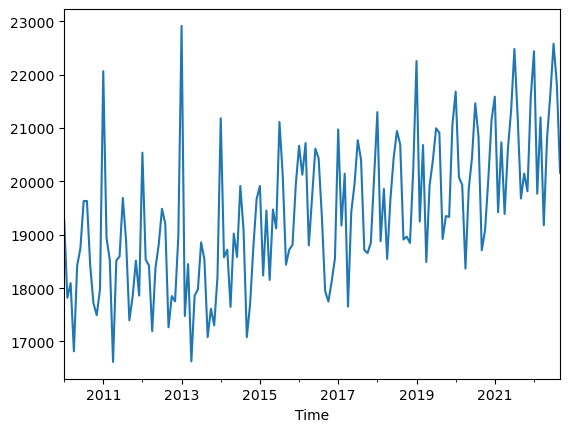

In [42]:
dataframe['Value'].plot()

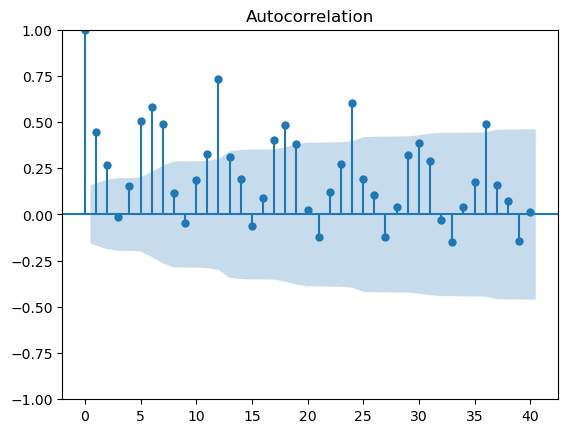

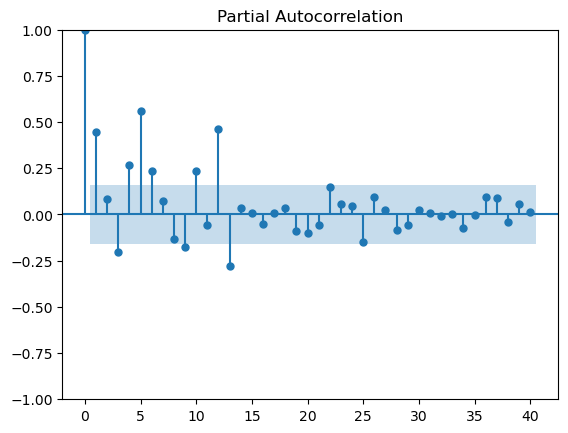

In [43]:
plot_acf(dataframe['Value'], lags=40);
plot_pacf(dataframe['Value'], method='ywm', lags=40);

# (q) How to determine ARIMA(p,d,q)(P,D,Q) from after-nonseasonal-differencing ACF and PACF graphs?
- p (nonseasonal ar order): after-nonseasonal-differencing pacf plot, sharp cut off after t-10 means p=10
- d (nonseasonal differencing): not observed from acf or pacf graph, it is inferred from time series data, d = number of differences needed to achieve stationarity of the time series graph of the raw prices, can also look for **unit root tests (like ADF test)**
- q (nonseasonal ma order): after-nonseasonal-differencing acf, sharp cut off after t-10 means q=10
- P (seasonal ar order): after-nonseasonal-differencing pacf plot, spikes at every 10th lag means p=10
- D (seasonal differencing): not seen from acf or pacf graph but inferred from time series graph of raw prices. The need for seasonal differencing can sometimes be seen as a seasonal pattern in the time series plot or seasonal spikes in the ACF that do not diminish after regular differencing.
- Q (seasonal ma order): acf, spikes at every 10 lags means Q = 10

### for stock market, common ranges
- p: 0 to 5 due to short term autocorrelation of prices
- d: 0 to 2, 1 is gradient, 2 is acceleration
- q: 0 to 5
- P: ?
- D: 0 to 2
- Q: ?

In [18]:
# Assuming 'dataframe' is your DataFrame and 'Value' is the column with time series data
s = df['Value'].dropna()  # Ensure there are no missing values

# Fit auto_arima function to TimeSeries s
model = pm.auto_arima(s, start_p=1, start_q=1,
                      max_p=3, max_q=3,
                      m=30,              # Set to the number of periods per season
                      d=None,           # Let model determine 'd'
                      seasonal=True,    # Enable Seasonality
                      start_P=0, 
                      D=0, 
                      start_Q=0,
                      max_P=3, 
                      max_D=2, 
                      max_Q=3,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# This function will return the best ARIMA model found according to the information criterion used (AIC by default).
# lower AIC is better
# [0] in ARIMA(2,0,1)(0,0,0)[0] means the model has no seasonal components

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2642.719, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2626.508, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=2631.767, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2640.725, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=2637.753, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[30] intercept   : AIC=2595.114, Time=2.73 sec
 ARIMA(1,1,0)(3,0,0)[30] intercept   : AIC=inf, Time=6.38 sec
 ARIMA(1,1,0)(2,0,1)[30] intercept   : AIC=2596.822, Time=3.86 sec
 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(3,0,1)[30] intercept   : AIC=2600.501, Time=15.58 sec
 ARIMA(0,1,0)(2,0,0)[30] intercept   : AIC=2606.056, Time=2.01 sec
 ARIMA(2,1,0)(2,0,0)[30] intercept   : AIC=2597.087, Time=3.56 sec
 ARIMA(1,1,1)(2,0,0)[30] intercept   : AIC=inf, Time=6.24 sec
 ARIMA(0,1,1)(2,0,0)[30] intercept   :

# Seaonal spike every 12 months for ACF graph. Employ seasonal differencing and estimate the time series model of C(t) with ARIMA(1,0,1) x (0,1,0)_12
- 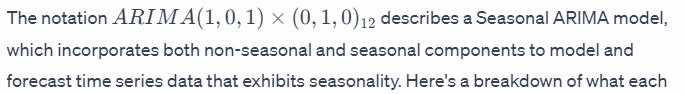
- [12]: shows the length of seasonal cycle in the data. This indicates the seasonal period, which is 12. For monthly data, this typically signifies an annual seasonality. It means that the seasonal differencing and any potential seasonal AR and MA components should consider this period.
-  if it is [0] then seaosnal compoenet of 0,1,0 means 1 month seasonal differnecing in monthly lag data. but if [12] then 0,1,0 means 1 years seasonal differencing in monthly lag data
- seasonal PDQ of [2,1,2][12] for monthly lags means ar show seasonal pattern at 24 months, seasonal differencing is done at 12 month, ma shows seasonal pattern at 24 months 


In [37]:
dataframe['Value'][12] - dataframe['Value'][0]

C:\Users\adam chem\AppData\Local\Temp\ipykernel_21220\4117367088.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataframe['Value'][12] - dataframe['Value'][0]


-482.09760000000097

In [44]:
value12 = dataframe['Value'] - dataframe['Value'].shift(12)
value12[:20]

Time
2010-01-01         NaN
2010-02-01         NaN
2010-03-01         NaN
2010-04-01         NaN
2010-05-01         NaN
2010-06-01         NaN
2010-07-01         NaN
2010-08-01         NaN
2010-09-01         NaN
2010-10-01         NaN
2010-11-01         NaN
2010-12-01         NaN
2011-01-01    2748.525
2011-02-01    1124.174
2011-03-01     434.257
2011-04-01    -199.131
2011-05-01      97.728
2011-06-01    -155.683
2011-07-01      57.163
2011-08-01    -748.604
Name: Value, dtype: float64

In [50]:
value12 = value12.dropna()
model0 = sm.tsa.statespace.SARIMAX(value12, trend = 'c',order=(1,0,1))  # trend='c' means to add a constant term to the time series data 
model0_fit=model0.fit(disp=0)
print(model0_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  141
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1122.882
Date:                Tue, 06 Feb 2024   AIC                           2253.764
Time:                        11:45:53   BIC                           2265.559
Sample:                    01-01-2011   HQIC                          2258.557
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    113.9905     56.836      2.006      0.045       2.594     225.387
ar.L1          0.5685      0.180      3.152      0.002       0.215       0.922
ma.L1         -0.2361      0.215     -1.099      0.2

C:\adam\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\adam\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# construct a prediction of c(t) using model.fit().predict() and plot actual versus predicted c(t)

2011-01-01     264.191167
2011-02-01    1172.409133
2011-03-01     764.416914
2011-04-01     438.793546
2011-05-01     151.384626
                 ...     
2022-05-01     126.240579
2022-06-01     212.139174
2022-07-01     258.836850
2022-08-01     207.283447
2022-09-01     370.331253
Freq: MS, Name: predicted_mean, Length: 141, dtype: float64
2011-01-01    21802.264833
2011-02-01    17771.533867
2011-03-01    17762.627086
2011-04-01    16178.080454
2011-05-01    18364.292374
                  ...     
2022-05-01    20684.641221
2022-06-01    21414.890826
2022-07-01    22320.520750
2022-08-01    21620.193053
2022-09-01    19791.598647
Length: 141, dtype: float64
mean abs error = 19243.75269583416


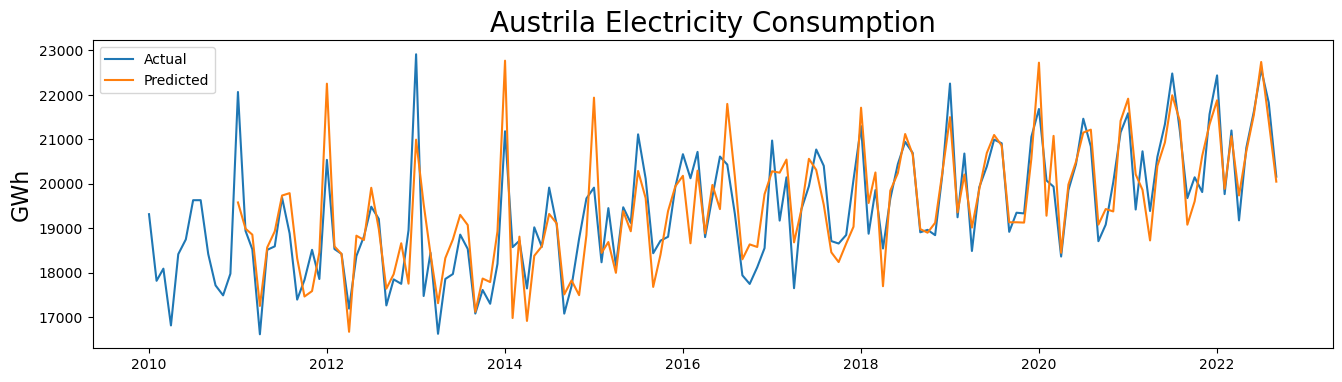

In [56]:
predictions1 = model0.fit().predict()  ### Note: 'predict' is just fitting here
print(predictions1)
err1=abs(predictions1-dataframe['Value'].dropna())
print(err1.dropna())
err1na=err1.dropna()
print("mean abs error =", np.sum(err1na)/err1na.size)

predict1=predictions1 + dataframe['Value'].shift(12)
## convert ln back to raw levels
Epredict1=predict1
plt.figure(figsize=(16,4))
plt.plot(dataframe['Value'], label="Actual")
plt.plot(Epredict1, label="Predicted")
plt.title('Austrila Electricity Consumption', fontsize=20)
plt.ylabel("GWh", fontsize=16)
plt.legend()

# What are the minimum and maximum percentage error in the prediction in Question 4? (Note percentage error can be positive or negative depending on whether the predicted value is larger or smaller than the actual.)